# 1.Load the packages

* python3.8.12  * 
cuda_11.6.1_511.
* 
cudnn_8.3.2.  .7.0

In [1]:
import torch
import torch as t
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchnet import meter
import xarray as xr
import rioxarray as rxr

In [2]:
# confirm that you have GPU environment
torch.cuda.is_available()

True

# 2.Prepare the data

In [3]:
# Read the input GRACE and features
precipitation_data = rxr.open_rasterio('D:/Onedrive/Acdemic/DL_grace/data/validation_all/prcp.tif').values
evaporation_data = rxr.open_rasterio('D:/Onedrive/Acdemic/DL_grace/data/validation_all/ET.tif').values
temperature_data = rxr.open_rasterio('D:/Onedrive/Acdemic/DL_grace/data/validation_all/temp.tif').values
CLSM_data = rxr.open_rasterio('D:/Onedrive/Acdemic/DL_grace/data/validation_all/CLSM.tif').values
grace_data = rxr.open_rasterio('D:/Onedrive/Acdemic/DL_grace/data/validation_all/grace.tif').values
template = rxr.open_rasterio('D:/Onedrive/Acdemic/DL_grace/data/CLSM_train/A200302.tif').values

# Convert the numpy to PyTorch tensor
precipitation_data = torch.tensor(precipitation_data, dtype=torch.float32)
evaporation_data = torch.tensor(evaporation_data, dtype=torch.float32)
temperature_data = torch.tensor(temperature_data, dtype=torch.float32)
CLSM_data = torch.tensor(CLSM_data, dtype=torch.float32)
grace_data = torch.tensor(grace_data, dtype=torch.float32)
template = torch.tensor(template, dtype=torch.float32)

# Normalization the data
precipitation_mean = torch.mean(precipitation_data, 0)
precipitation_std = torch.std(precipitation_data, 0)
precipitation = (precipitation_data - precipitation_mean) / precipitation_std

evaporation_mean = torch.mean(evaporation_data, 0)
evaporation_std = torch.std(evaporation_data, 0)
evaporation = (evaporation_data - evaporation_mean) / evaporation_std

temperature_mean = torch.mean(temperature_data, 0)
temperature_std = torch.std(temperature_data, 0)
temperature = (temperature_data - temperature_mean) / temperature_std

CLSM_mean = torch.mean(CLSM_data, 0)
CLSM_std = torch.std(CLSM_data, 0)
CLSM = (CLSM_data - CLSM_mean) / CLSM_std

grace_mean = torch.mean(grace_data, 0)
grace_std = torch.std(grace_data, 0)
grace = (grace_data - grace_mean) / grace_std

mask = template.reshape(-1,1)

grace_re = grace_data.reshape(214,-1).transpose(0,1)
CLSM_re = CLSM.reshape(214,-1).transpose(0,1)
evaporation_re = evaporation.reshape(214,-1).transpose(0,1)
precipitation_re = precipitation.reshape(214,-1).transpose(0,1)
temperature_re = temperature.reshape(214,-1).transpose(0,1)

In [4]:
# Delete the non-value ocean value
# First create the mask
import random
matrix = torch.mean(torch.stack([torch.mean(CLSM_re, 1), torch.mean(evaporation_re, 1), torch.mean(precipitation_re, 1), torch.mean(temperature_re, 1)], 1), 1).flatten()
matrix[torch.isnan(matrix)] = 0
non_negative_indices = torch.nonzero(matrix)

CLSM_re = CLSM_re[non_negative_indices.flatten(), :]
grace_re = grace_re[non_negative_indices.flatten(), :]
evaporation_re = evaporation_re[non_negative_indices.flatten(), :]
precipitation_re = precipitation_re[non_negative_indices.flatten(), :]
temperature_re = temperature_re[non_negative_indices.flatten(), :]

# 3.Set the HyperParameter

In [5]:
class Config(object):
    t0 = 203
    t1 = 11 
    t = t0 + t1
    train_num = 8000
    validation_num = 1000
    test_num = 1000
    in_channels = 5
    lr = .0005
    epochs = 40
    batch_size = 200

# 4.Load the data

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F

class time_series_decoder(Dataset):
    
    def __init__(self,t0=Config.t0,N=Config.t,dx=None,dy=None,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            dx: input features
            dy: out put GRACE TWSA
        """
        self.t0 = t0
        self.transform = None

        self.x = dx  
        self.fx = dy
        self.masks = self._generate_square_subsequent_mask(t0) 
        # confirm output shape
        print("x: ",self.x.shape,
              "fx: ",self.fx.shape)
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.x[idx,:,:],
                  self.fx[idx,:],
                  self.masks)
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,t0):
        mask = torch.zeros(Config.t,Config.t)
        for i in range(0,Config.t0):
            mask[i,Config.t0:] = 1 
        for i in range(Config.t0,Config.t):
            mask[i,i+1:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))
        return mask

In [7]:
random.seed(0)

random_indices = random.sample(range(non_negative_indices.shape[0]), Config.train_num)
random_indices1 = random.sample(range(non_negative_indices.shape[0]), Config.validation_num)
random_indices2 = random.sample(range(non_negative_indices.shape[0]), Config.test_num)
dx = torch.stack([torch.cat(Config.train_num*[torch.arange(0,Config.t).type(torch.float).unsqueeze(0)]).cuda(), CLSM_re[np.array([random_indices]).flatten(),0:Config.t].cuda(), evaporation_re[np.array([random_indices]).flatten(),0:Config.t].cuda(),precipitation_re[np.array([random_indices]).flatten(),0:Config.t].cuda(), temperature_re[np.array([random_indices]).flatten(),0:Config.t].cuda()], 1)
dx1 = torch.stack([torch.cat(Config.validation_num*[torch.arange(0,Config.t).type(torch.float).unsqueeze(0)]).cuda(), CLSM_re[np.array([random_indices1]).flatten(),0:Config.t].cuda(), evaporation_re[np.array([random_indices1]).flatten(),0:Config.t].cuda(),precipitation_re[np.array([random_indices1]).flatten(),0:Config.t].cuda(), temperature_re[np.array([random_indices1]).flatten(),0:Config.t].cuda()], 1)
dx2 = torch.stack([torch.cat(Config.test_num*[torch.arange(0,Config.t).type(torch.float).unsqueeze(0)]).cuda(), CLSM_re[np.array([random_indices2]).flatten(),0:Config.t].cuda(), evaporation_re[np.array([random_indices2]).flatten(),0:Config.t].cuda(),precipitation_re[np.array([random_indices2]).flatten(),0:Config.t].cuda(), temperature_re[np.array([random_indices2]).flatten(),0:Config.t].cuda()], 1)
train_dataset = time_series_decoder(t0=Config.t0,N=Config.train_num,dx=dx ,dy=grace_re[np.array([random_indices]).flatten(),0:Config.t].unsqueeze(1))
validation_dataset = time_series_decoder(t0=Config.t0,N=Config.validation_num,dx=dx1,dy=grace_re[np.array([random_indices1]).flatten(),0:Config.t].unsqueeze(1))
test_dataset = time_series_decoder(t0=Config.t0,N=Config.test_num,dx=dx2,dy=grace_re[np.array([random_indices2]).flatten(),0:Config.t].unsqueeze(1))

x:  torch.Size([8000, 5, 214]) fx:  torch.Size([8000, 1, 214])
x:  torch.Size([1000, 5, 214]) fx:  torch.Size([1000, 1, 214])
x:  torch.Size([1000, 5, 214]) fx:  torch.Size([1000, 1, 214])


In [8]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset,Config.batch_size,shuffle=True, generator=torch.Generator(device='cuda'))
validation_dl = DataLoader(validation_dataset,Config.batch_size, generator=torch.Generator(device='cuda'))
test_dl = DataLoader(test_dataset,Config.batch_size, generator=torch.Generator(device='cuda'))

# 5.Build the model

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = context_embedding(Config.in_channels+1,256,40)
        self.positional_embedding = torch.nn.Embedding(512,256)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=256,nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3)
        
        self.fc1 = torch.nn.Linear(256,1)
        
    def forward(self,x,y,attention_masks):
        
        z = torch.cat((y,x),1)

        z_embedding = self.input_embedding(z).unsqueeze(1).permute(3, 1, 0, 2)
        x1 = x.type(torch.long)
        x1[x1 < 0] = 0
        positional_embeddings = self.positional_embedding(x1).permute(2, 1, 0, 3)
        
        input_embedding = z_embedding+positional_embeddings
        input_embedding1 = torch.mean(input_embedding, 1)
        transformer_embedding = self.transformer_decoder(input_embedding1,attention_masks)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        
        return output


class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.__padding = (kernel_size - 1) * dilation
        
    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))


class context_embedding(torch.nn.Module):
    def __init__(self,in_channels=Config.in_channels,embedding_size=256,k=40):
        super(context_embedding,self).__init__()
        self.causal_convolution = CausalConv1d(in_channels,embedding_size,kernel_size=k)

    def forward(self,x):
        x = self.causal_convolution(x)
        return torch.tanh(x)

# 6.Training the dataset

In [10]:
criterion = torch.nn.MSELoss()

In [11]:
model = TransformerTimeSeries().cuda()
DEVICE = torch.device("cuda:0")
model.to(DEVICE)

lr = Config.lr # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr)

def Dp(y_pred,y_true,q):
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])
def Rp_num_den(y_preds,y_trues,q):
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [12]:
def train_epoch(model,train_dl,t0=Config.t0):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,y,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
        loss = criterion(output.squeeze()[:,(Config.t0-1):(Config.t-1)],y.cuda()[:,0,Config.t0:])
        loss.backward()
        optimizer.step()
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n
    
def eval_epoch(model,validation_dl,t0=Config.t0):
    model.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            loss = criterion(output.squeeze()[:,(Config.t0-1):(Config.t-1)],y.cuda()[:,0,Config.t0:]) 
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]
    return eval_loss/n
    
def test_epoch(model,test_dl,t0=Config.t0):
    with torch.no_grad():
        predictions = []
        observations = []
        model.eval()
        for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            for p,o in zip(output.squeeze()[:,(Config.t0-1):(Config.t-1)].cpu().numpy().tolist(),y.cuda()[:,0,Config.t0:].cpu().numpy().tolist()): 
                predictions.append(p)
                observations.append(o)
        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
    return Rp
    
train_epoch_loss = []
eval_epoch_loss = []
Rp_best = 10

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = 'cuda'

for e,epoch in enumerate(range(Config.epochs)):
    train_loss = []
    eval_loss = []
    
    l_t = train_epoch(model,train_dl,Config.t0)
    train_loss.append(l_t)
    
    l_e = eval_epoch(model,validation_dl,Config.t0)
    eval_loss.append(l_e)
    
    Rp = test_epoch(model,test_dl,Config.t0)

    if Rp_best > Rp:
        Rp_best = Rp
        
    train_epoch_loss.append(np.mean(train_loss))
    eval_epoch_loss.append(np.mean(eval_loss))
    
    print("Epoch {}: Train loss: {} \t Validation loss: {} \t R_p={}".format(e,
                                                             np.mean(train_loss),
                                                             np.mean(eval_loss),Rp))

Epoch 0: Train loss: 491.4299562454224 	 Validation loss: 130.66528930664063 	 R_p=0.5944588943229695
Epoch 1: Train loss: 430.68971214294436 	 Validation loss: 108.97263641357422 	 R_p=0.565349314802755
Epoch 2: Train loss: 406.9369255065918 	 Validation loss: 90.61003341674805 	 R_p=0.47878997374918075
Epoch 3: Train loss: 387.6899151325226 	 Validation loss: 82.25723114013672 	 R_p=0.4833981147376529
Epoch 4: Train loss: 371.88333048820493 	 Validation loss: 69.40227508544922 	 R_p=0.4148887988366964
Epoch 5: Train loss: 357.622874212265 	 Validation loss: 64.58794288635254 	 R_p=0.4193620861283297
Epoch 6: Train loss: 345.60708298683164 	 Validation loss: 58.230553817749026 	 R_p=0.4089945596279884
Epoch 7: Train loss: 338.3307314872742 	 Validation loss: 53.48532981872559 	 R_p=0.39557309386061956
Epoch 8: Train loss: 323.99437379837036 	 Validation loss: 46.465275573730466 	 R_p=0.3573176935615781
Epoch 9: Train loss: 311.6702777147293 	 Validation loss: 42.58474273681641 	 R_p=0

# 7.See the model performance

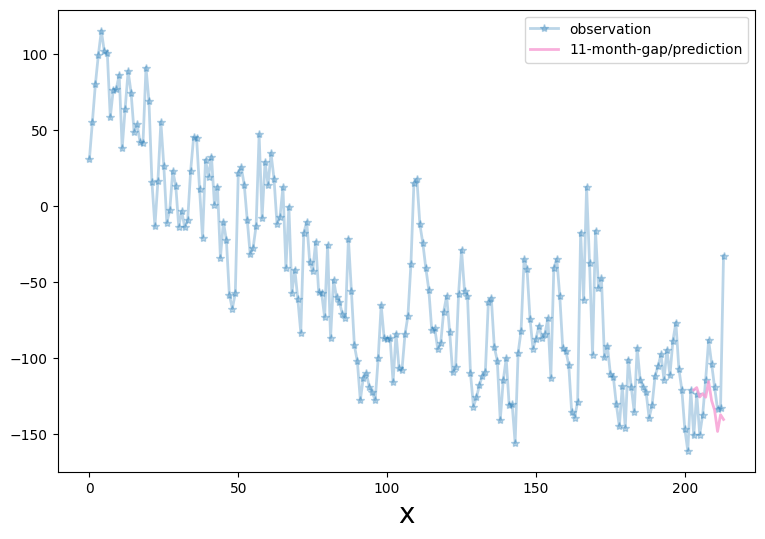

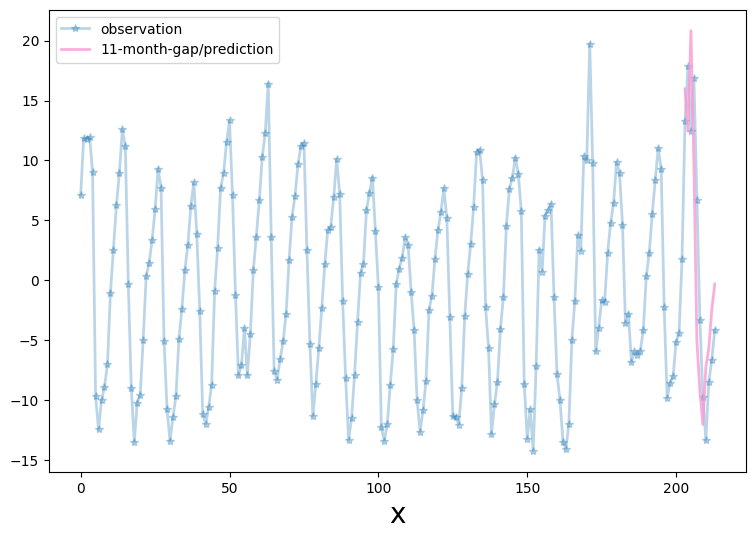

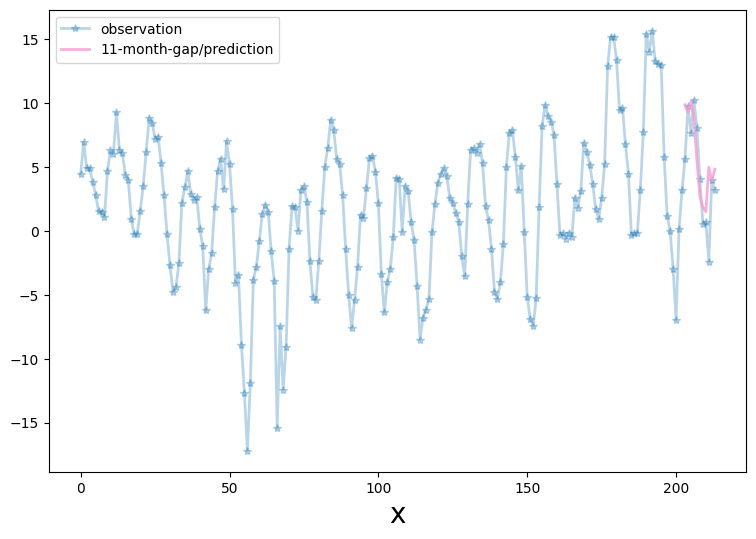

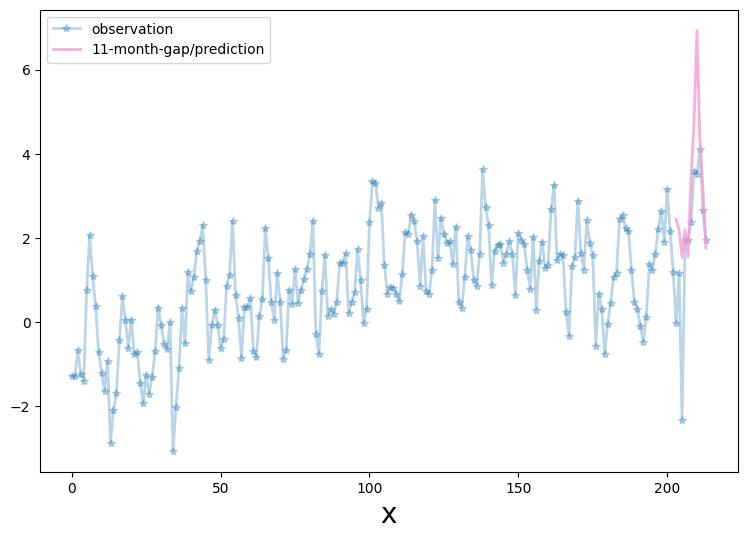

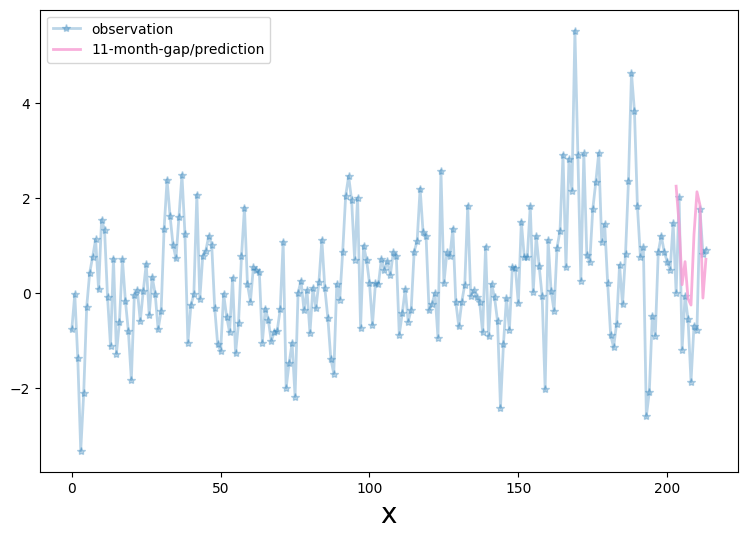

In [13]:
import os
import scipy.stats as st
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

data_points = 70
n_plots = 5
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(test_dl):

        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
        if step > n_plots:
            break
        
        with torch.no_grad():
            plt.figure(figsize=(9,6))
 
            plt.plot(x[0,0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'-*',linewidth=2, alpha=0.3)
            plt.plot(x[0,0,Config.t0:].cpu().detach().squeeze().numpy(),output[0,(Config.t0):(Config.t)].cpu().detach().squeeze().numpy(),linewidth=2, color = '#F79BD3', alpha=0.8) # not missing data


            plt.xlabel("x",fontsize=20)
            plt.legend(['observation', '11-month-gap/prediction'])
            plt.show()

In [14]:
matrix = torch.empty(0)
obsmat = torch.empty(0)
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(test_dl):
        # if step == 8:
        #     break
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
        matrix = torch.cat((matrix, output))
        obsmat = torch.cat((obsmat, y.cuda()))

pre = matrix.cpu().detach().numpy()
obs = obsmat.cpu().detach().numpy()
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data
df = pd.DataFrame({
  'obs': obs[:, 0, Config.t0:Config.t].flatten(),
  'pre': pre[:, Config.t0:Config.t, 0].flatten()
})
df

,obs,pre
0,-150.934937,-120.960526
1,-123.702354,-119.415909
2,-150.364426,-125.584915
3,-137.391083,-123.390610
4,-114.271523,-125.770668
...,...,...
10995,3.347998,3.311789
10996,6.324612,4.756097
10997,8.920279,6.140007
10998,4.474336,2.984844


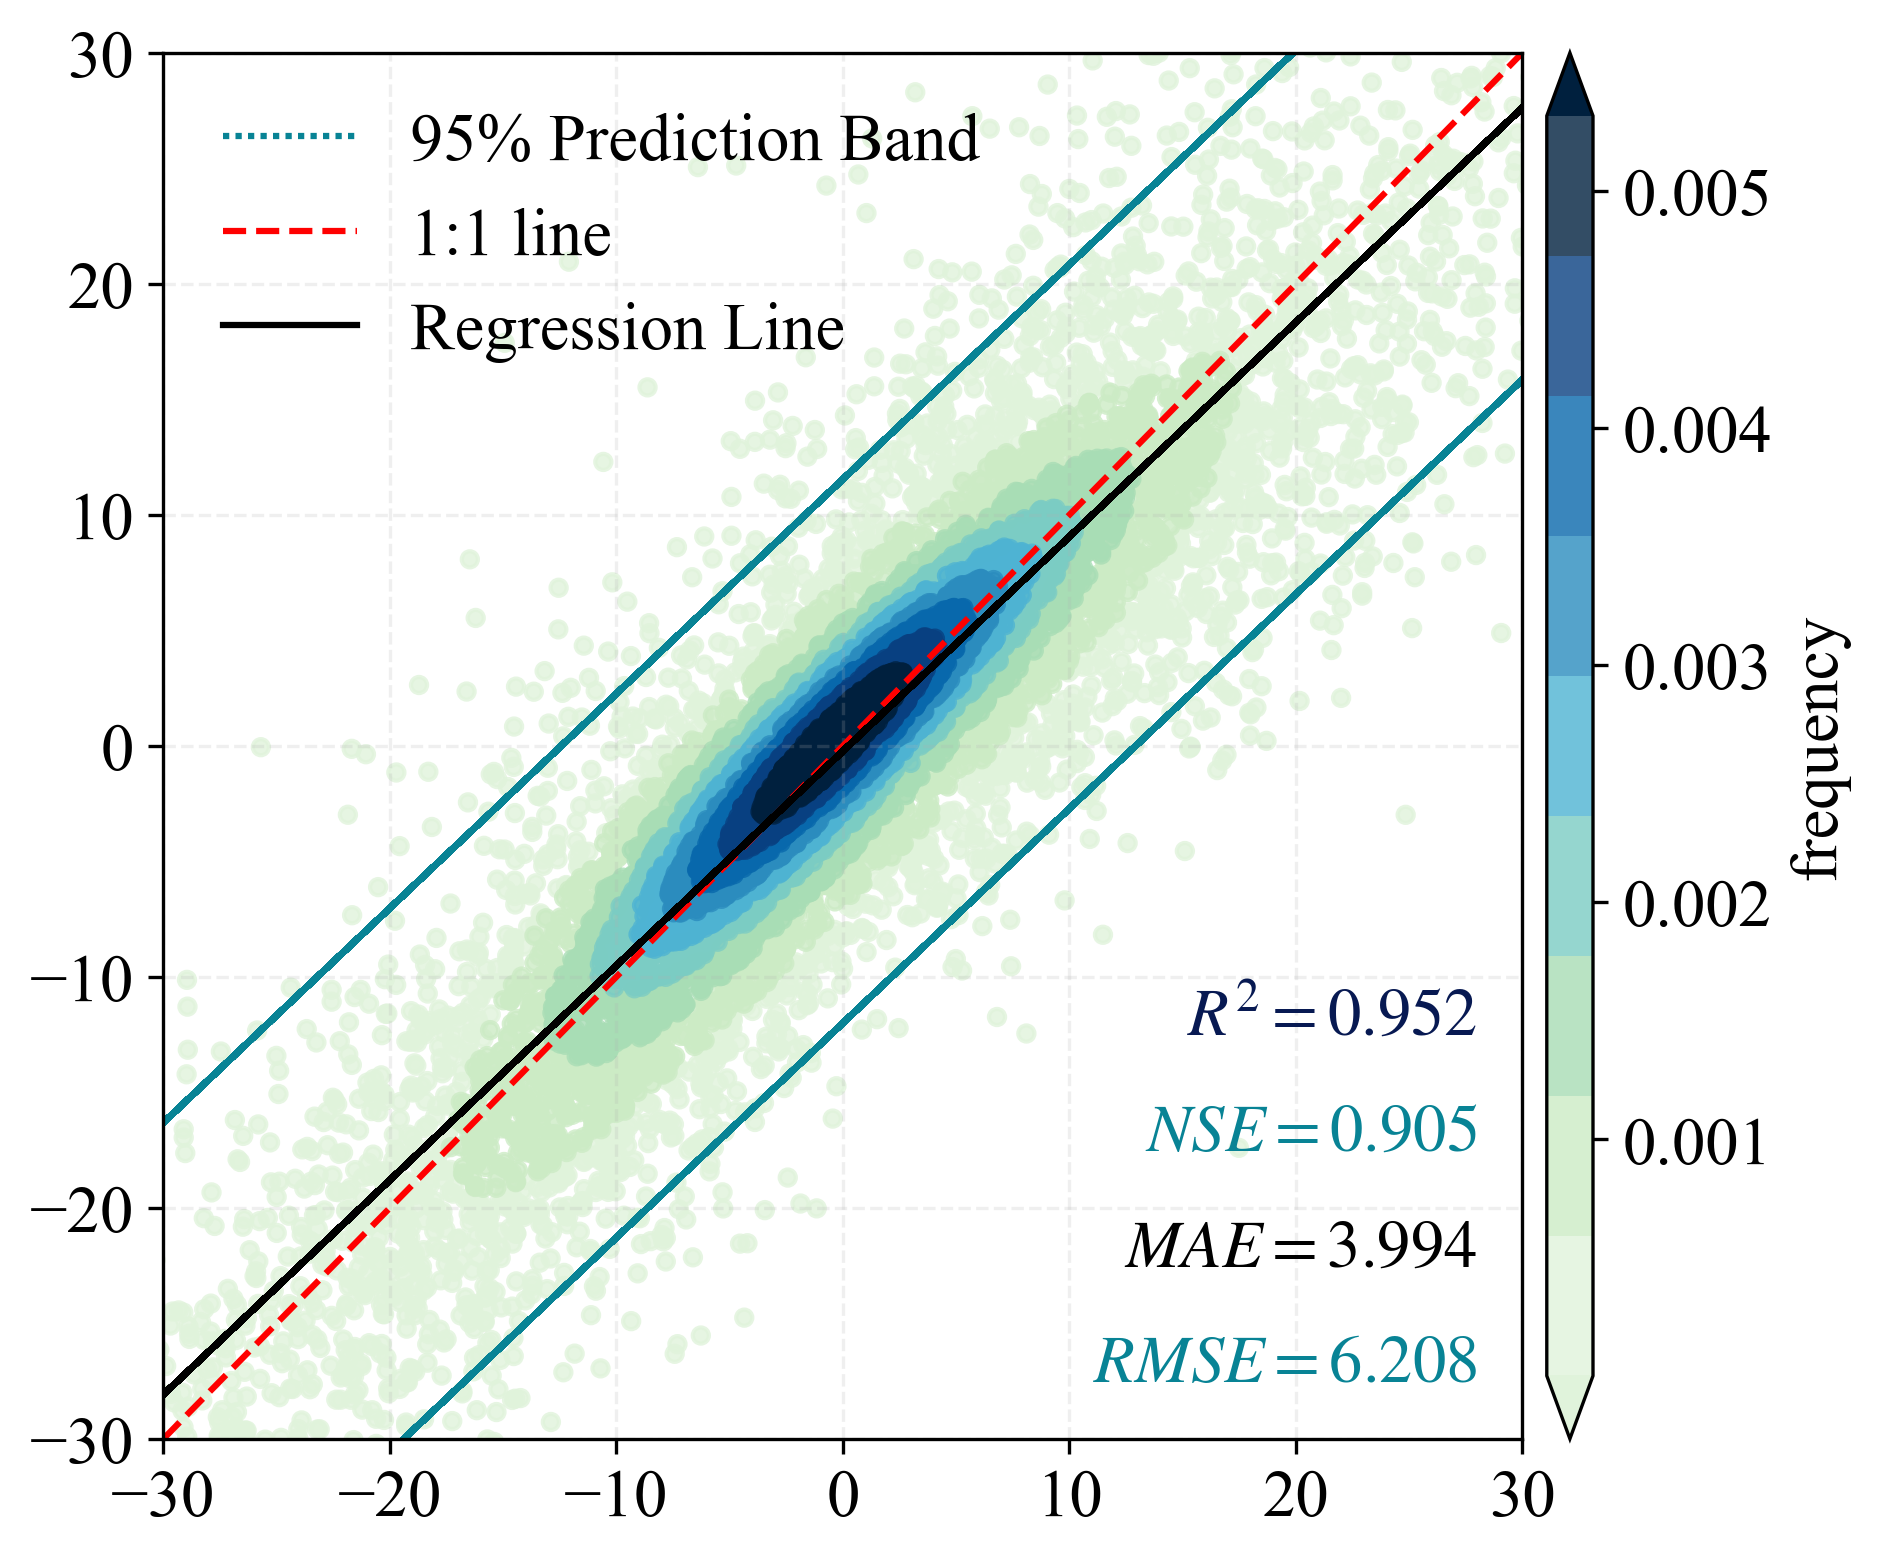

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rcParams
from statistics import mean
from sklearn.metrics import explained_variance_score,r2_score,median_absolute_error,mean_squared_error,mean_absolute_error
from scipy.stats import pearsonr
import cmaps

config = {"font.family":'Times New Roman',"font.size": 16,"mathtext.fontset":'stix'}
rcParams.update(config)
scale = 30
confidence_level = 0.95

x = df['obs']; y = df['pre']

BIAS = mean(x - y)
MSE = mean_squared_error(x, y)
RMSE = np.power(MSE, 0.5)
R2 = pearsonr(x, y).statistic
adjR2 = 1-((1-r2_score(x,y))*(len(x)-1))/(len(x)-5-1)
MAE = mean_absolute_error(x, y)
EV = explained_variance_score(x, y)
NSE = 1 - (RMSE ** 2 / np.var(x))
# 计算散点密度
xy = np.vstack([x, y])
z = stats.gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x.iloc[idx], y.iloc[idx], z[idx] 

def slope(xs, ys):
    m = (((mean(xs) * mean(ys)) - mean(xs * ys)) / ((mean(xs) * mean(xs)) - mean(xs * xs)))
    b = mean(ys) - m * mean(xs)
    return m, b
k, b = slope(x, y)
regression_line = []
for a in x:
    regression_line.append((k * a) + b)
slope, intercept = np.polyfit(x, regression_line, 1)
n = 1
t_value = 1.95 
std_err = np.std(y - (slope * x + intercept))
margin_of_error = t_value * (std_err / np.sqrt(n))
lower_confidence_bound = slope * x + intercept - margin_of_error
upper_confidence_bound = slope * x + intercept + margin_of_error

fig, ax = plt.subplots(figsize=(7, 6), dpi=300)
plt.plot(x, lower_confidence_bound, linestyle='-', color='#088395', dashes=(1, 1), label='95% Prediction Band')
plt.plot(x, upper_confidence_bound, linestyle='-', color='#088395', dashes=(1, 1))
scatter = ax.scatter(x, y, marker='o', c=z, edgecolors=None, s=15, cmap=cmaps.CBR_wet[2:],  alpha=0.8)
cbar = plt.colorbar(scatter, shrink=1, orientation='vertical', extend='both', pad=0.015, aspect=30, label='frequency')
plt.plot([-scale, scale], [-scale, scale], 'red', lw=1.5, linestyle='--', label='1:1 line')  # 画的1:1线，线的颜色为black，线宽为0.8
plt.plot(x, regression_line, 'black', lw=1.5, label='Regression Line')  # 预测与实测数据之间的回归线
ax.grid(True, linestyle='--', alpha=0.2)



plt.text(28,-12.5, '$R^2=%.3f$' % R2, family = 'Times New Roman', horizontalalignment='right', color='#071952')
plt.text(28,-17.5, '$NSE=%.3f$' % NSE, family = 'Times New Roman', horizontalalignment='right', color='#088395')

plt.text(28,-22.5, '$MAE=%.3f$' % MAE, family = 'Times New Roman', horizontalalignment='right')
plt.text(28,-27.5, '$RMSE=%.3f$' % RMSE, family = 'Times New Roman', horizontalalignment='right',color='#088395')



plt.axis([-scale, scale, -scale, scale])  # 设置线的范围
ax.legend(loc='upper left', frameon = False)
#plt.savefig('D:/Onedrive/Acdemic/DL_grace/figure/scatter/Tr5_v3.png', format="png", dpi=300, bbox_inches = 'tight')
plt.show()